In [ ]:
#cond  4.507766x10^12
import os
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import scipy


def inite(elec,orb):
    config=[]
    list1=[]
    #singles
    for x in range(elec):
        count=orb-elec
        while (count<orb):
            for e in range(elec):
                if x==e:
                    if x%2==0:
                        config.append(count)
                        count=count+2
                    else:
                        config.append(count+1)
                        count=count+2
                else:
                    config.append(e)
                
            list1.append(config)
            config=[]
    #doubles
    for x in range(elec):
        for y in range(x+1,elec):
            count1=orb-elec
            count2=orb-elec
            for count1 in range(elec, orb, 2):
                for count2 in range(elec, orb, 2):
                    cont=0
                    if count1==count2:
                        if (x%2)!=(y%2):
                            cont=1
                    else:
                        cont=1
                    if (x%2)==(y%2) and count2<count1:
                        cont=0
                    if cont==1:    
                        for e in range(elec):
                            if x==e:
                                if x%2==0:
                                    config.append(count1)
                                else:
                                    config.append(count1+1)
                            elif y==e:
                                if y%2==0:
                                    config.append(count2)
                                else:
                                    config.append(count2+1)
                            else:
                                config.append(e)

                        list1.append(config)
                        config=[]
    return list1

def gs_exact(symbols, geometry, active_electrons, active_orbitals, charge, shots=None, max_iter=100):
    # Build the electronic Hamiltonian
    H, qubits = qml.qchem.molecular_hamiltonian(symbols, geometry, basis="sto-3g", method="pyscf", active_electrons=active_electrons, active_orbitals=active_orbitals, charge=charge)
    hf_state = qml.qchem.hf_state(active_electrons, qubits)
    singles, doubles = qml.qchem.excitations(active_electrons, qubits)
    # Map excitations to the wires the UCCSD circuit will act on
    s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)

    wires=range(qubits)
    params = np.zeros(len(singles) + len(doubles))
    # Define the device
    dev = qml.device("default.qubit", wires=qubits, shots=shots)
    
    # Define the qnode
    if shots==None:
        @qml.qnode(dev, interface="autograd", diff_method="adjoint")
        def circuit(params, wires, s_wires, d_wires, hf_state):
            qml.UCCSD(params, wires, s_wires, d_wires, hf_state)
            return qml.expval(H)
    else:
        @qml.qnode(dev, interface="autograd")
        def circuit(params, wires, s_wires, d_wires, hf_state):
            qml.UCCSD(params, wires, s_wires, d_wires, hf_state)
            return qml.expval(H)

    optimizer = qml.GradientDescentOptimizer(stepsize=2.0)
    for n in range(max_iter):
        params, energy = optimizer.step_and_cost(circuit, params, wires=range(qubits),
                                                 s_wires=s_wires, d_wires=d_wires,
                                                 hf_state=hf_state)

    print(circuit(params, wires, s_wires, d_wires, hf_state))
    return params
def ee_exact(symbols, geometry, active_electrons,  active_orbitals, charge,params,shots=0):
    # Build the electronic Hamiltonian
    H, qubits = qml.qchem.molecular_hamiltonian(symbols, geometry, basis="sto-3g", method="pyscf", active_electrons=active_electrons, active_orbitals=active_orbitals, charge=charge)
    singles, doubles = qml.qchem.excitations(active_electrons, qubits)
    # Map excitations to the wires the UCCSD circuit will act on
    s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)
    wires=range(qubits)

    null_state = np.zeros(qubits,int)
    list1 = inite(active_electrons,qubits)
    values =[]
    for t in range(10):
        if shots==0:
            #dev = qml.device("default.qubit", wires=qubits)
            dev = qml.device("default.qubit", wires=qubits)
        else:
            #dev = qml.device("default.qubit", wires=qubits,shots=shots)
            dev = qml.device("default.qubit", wires=qubits,shots=shots)
        #circuit for diagonal part
        @qml.qnode(dev)
        def circuit_d(params, occ,wires, s_wires, d_wires, hf_state):
            for w in occ:
                qml.X(wires=w)
            qml.UCCSD(params, wires, s_wires, d_wires, hf_state)
            return qml.expval(H)
        #circuit for off-diagonal part
        @qml.qnode(dev)
        def circuit_od(params, occ1, occ2,wires, s_wires, d_wires, hf_state):
            for w in occ1:
                qml.X(wires=w)
            first=-1
            for v in occ2:
                if v not in occ1:
                    if first==-1:
                        first=v
                        qml.Hadamard(wires=v)
                    else:
                        qml.CNOT(wires=[first,v])
            for v in occ1:
                if v not in occ2:
                    if first==-1:
                        first=v
                        qml.Hadamard(wires=v)
                    else:
                        qml.CNOT(wires=[first,v])
            qml.UCCSD(params, wires, s_wires, d_wires, hf_state)
            return qml.expval(H)
        #final M matrix
        M = np.zeros((len(list1),len(list1)))
        for i in range(len(list1)):
            for j in range(len(list1)):
                if i == j:
                    M[i,i] = circuit_d(params, list1[i], wires, s_wires, d_wires, null_state)
        #print("diagonal parts done")
        for i in range(len(list1)):
            for j in range(len(list1)):
                if i!=j:
                    Mtmp = circuit_od(params, list1[i],list1[j],wires, s_wires, d_wires, null_state)
                    M[i,j]=Mtmp-M[i,i]/2.0-M[j,j]/2.0
        #print("off diagonal terms done")
        #ERROR:not subtracting the gs energy
        eig,evec=np.linalg.eig(M)
        values.append(np.sort(eig))
    return values



# Define the molecule
r = 1.88973
symbols  = ['N', 'H', 'H', 'H']
geometry = np.array([[0.0, 0.0,  0.0],
                     [0.0, 0.0,  8.906*r],
                     [0.8121*r, -0.4688*r, 0.3816*r],
                     [-0.8121*r, -0.4688*r, 0.3816*r]
                     ], requires_grad = False)
active_electrons = 4
active_orbitals = 4

charge = 0
params = gs_exact(symbols,geometry, active_electrons, active_orbitals, charge,max_iter=50)
#params_exact=params

total_energy = ee_exact(symbols, geometry, active_electrons, active_orbitals, charge,params)
print('exact eigenvalues:\n', total_energy)


-55.30003930467209
exact eigenvalues:
 [tensor([-55.29991574, -55.20896263, -55.2085443 , -54.81290141,
        -54.81283934, -54.74246643, -54.74175912, -54.69343813,
        -54.68595743, -54.68112426, -54.66209722, -54.65799652,
        -54.63706918, -54.58962324, -54.58099609, -54.45108294,
        -54.26983737, -54.18987759, -54.17758307, -54.1338018 ,
        -54.05596839, -53.9411944 , -53.81461618, -53.78750464,
        -53.73182985, -53.62327656], requires_grad=True), tensor([-55.29991574, -55.20896263, -55.2085443 , -54.81290141,
        -54.81283934, -54.74246643, -54.74175912, -54.69343813,
        -54.68595743, -54.68112426, -54.66209722, -54.65799652,
        -54.63706918, -54.58962324, -54.58099609, -54.45108294,
        -54.26983737, -54.18987759, -54.17758307, -54.1338018 ,
        -54.05596839, -53.9411944 , -53.81461618, -53.78750464,
        -53.73182985, -53.62327656], requires_grad=True), tensor([-55.29991574, -55.20896263, -55.2085443 , -54.81290141,
        -54.

In [2]:
eig1k = ee_exact(symbols, geometry, active_electrons, active_orbitals, charge,params, shots=1000)
print('exact eigenvalues:\n', eig1k)

exact eigenvalues:
 [tensor([-55.28795494+0.j        , -55.2307618 +0.j        ,
        -55.20007933+0.j        , -54.82999717+0.j        ,
        -54.78408216+0.j        , -54.7408848 +0.j        ,
        -54.73819988-0.03315729j, -54.73819988+0.03315729j,
        -54.67521335+0.j        , -54.65364793+0.j        ,
        -54.64784972-0.0322329j , -54.64784972+0.0322329j ,
        -54.60415335-0.01824697j, -54.60415335+0.01824697j,
        -54.59958446+0.j        , -54.43816524+0.j        ,
        -54.28311974+0.j        , -54.182747  -0.00217943j,
        -54.182747  +0.00217943j, -54.11145633-0.01567816j,
        -54.11145633+0.01567816j, -53.9634506 +0.j        ,
        -53.82873199+0.j        , -53.76741067-0.02446461j,
        -53.76741067+0.02446461j, -53.61431816+0.j        ], requires_grad=True), tensor([-55.3033734 +0.j        , -55.23491106+0.j        ,
        -55.17648094+0.j        , -54.83020636+0.j        ,
        -54.78611569-0.00834411j, -54.78611569+0.00834411

In [3]:
# Calculate the mean for each position
means_1k = np.mean(eig1k, axis=0)

print("Means of each position:", means_1k)

error = eig1k - means_1k

# Define the number of columns (26 columns)
num_columns = 26

error_dict = {}
val_1k = []

for i in range(num_columns):  
    if i == 0:
        error_name = "error_gr"  # First error variable is 'error_gr'
    else:
        error_name = f"error_ex{i}"  # Subsequent error variables are 'error_ex1', 'error_ex2', ...

    
    #error_name = f"error_ex{i+1}"  
    error_dict[error_name] = error[:, i]
    print(f"{error_name}: {error_dict[error_name]}")

for i, error_name in enumerate(error_dict):
    error_list = error_dict[error_name]  
        
# Variance
    if len(error_list) > 1:
        variance = sum(e**2 for e in error_list) / len(error_list)
    
    # Append the variance to the val_1k list
        val_1k.append(variance)
        print(f"Variance for {error_name}: {variance.real}")

Means of each position: [-55.29977504+0.j         -55.22663789-0.00501775j
 -55.20136643+0.00501775j -54.84702165+0.j
 -54.79727154-0.00402943j -54.75857926+0.00065806j
 -54.73130267-0.00176606j -54.71320883-0.00061723j
 -54.69230613+0.00144719j -54.67338415+0.00029862j
 -54.65818007-0.01743852j -54.65118003+0.00832196j
 -54.62954156+0.0090713j  -54.58850957-0.00349052j
 -54.57143622+0.00754462j -54.44520795+0.j
 -54.27751184-0.00040913j -54.19058209-0.00093514j
 -54.16893023-0.0074448j  -54.13705743+0.00722126j
 -54.06780303+0.00156782j -53.94183033+0.j
 -53.81326971-0.00305412j -53.78162505-0.00038834j
 -53.74075215+0.00344247j -53.62080971+0.j        ]
error_gr: [ 0.01182011+0.j -0.00359835+0.j  0.00369329+0.j -0.00249904+0.j
 -0.0195083 +0.j -0.0149878 +0.j  0.02361771+0.j -0.00387861+0.j
 -0.01016428+0.j  0.01550527+0.j]
error_ex1: [-0.00412391+0.00501775j -0.00827316+0.00501775j -0.00492728+0.00501775j
 -0.01960593+0.00501775j  0.02046972+0.00501775j  0.00926034+0.00501775j
  0.0

In [4]:
eig10k = ee_exact(symbols, geometry, active_electrons, active_orbitals, charge,params, shots=10000)
print('exact eigenvalues:\n', eig10k)

exact eigenvalues:
 [tensor([-55.29804813+0.j        , -55.21284829+0.j        ,
        -55.20820669+0.j        , -54.8218319 +0.j        ,
        -54.81356119+0.j        , -54.744555  +0.j        ,
        -54.73245864+0.j        , -54.69760388+0.j        ,
        -54.68470373+0.j        , -54.67072718+0.j        ,
        -54.66505921+0.j        , -54.64934027+0.j        ,
        -54.64470439+0.j        , -54.5905477 -0.01032019j,
        -54.5905477 +0.01032019j, -54.45208007+0.j        ,
        -54.26994027+0.j        , -54.18449122-0.00174987j,
        -54.18449122+0.00174987j, -54.14154845+0.j        ,
        -54.05432427+0.j        , -53.93709378+0.j        ,
        -53.81177809+0.j        , -53.7934223 +0.j        ,
        -53.72567119+0.j        , -53.62110034+0.j        ], requires_grad=True), tensor([-55.30495824+0.j       , -55.22187245+0.j       ,
        -55.19841789+0.j       , -54.82344301+0.j       ,
        -54.81674384+0.j       , -54.74757861+0.j       ,
   

In [5]:
# Calculate the mean for each position
means_10k = np.mean(eig10k, axis=0)

print("Means of each position:", means_10k)

error = eig10k - means_10k

# Define the number of columns (26 columns)
num_columns = 26

error_dict = {}
val_10k = []

for i in range(num_columns):  
    if i == 0:
        error_name = "error_gr"  # First error variable is 'error_gr'
    else:
        error_name = f"error_ex{i}"  # Subsequent error variables are 'error_ex1', 'error_ex2', ...

    
    #error_name = f"error_ex{i+1}"  
    error_dict[error_name] = error[:, i]
    print(f"{error_name}: {error_dict[error_name]}")

for i, error_name in enumerate(error_dict):
    error_list = error_dict[error_name]  
        
# Variance
    if len(error_list) > 1:
        variance = sum(e**2 for e in error_list) / len(error_list)
    
    # Append the variance to the val_10k list
        val_10k.append(variance)
        print(f"Variance for {error_name}: {variance.real}")

Means of each position: [-55.3023222 +0.j         -55.21723619-0.00025324j
 -55.2054028 +0.00025324j -54.82020895-0.00073494j
 -54.81222738+0.00073494j -54.74415388-0.00123002j
 -54.73716545+0.00123002j -54.69479752-0.00068224j
 -54.68393697+0.00021952j -54.67403761-0.00162256j
 -54.66245556+0.00042152j -54.65359849+0.00095075j
 -54.63864066+0.00071301j -54.59210064-0.00290017j
 -54.58230028+0.00290017j -54.45175624+0.j
 -54.27035392+0.j         -54.18866635-0.00069106j
 -54.17998173+0.00069106j -54.13404059+0.j
 -54.05297168+0.j         -53.94110975+0.j
 -53.81423419+0.j         -53.7897766 +0.j
 -53.73104912+0.j         -53.62272671+0.j        ]
error_gr: [ 0.00427407+0.j -0.00263604+0.j  0.00044416+0.j  0.00128469+0.j
  0.0004221 +0.j  0.00049681+0.j -0.00519009+0.j  0.00305067+0.j
  0.00085819+0.j -0.00300455+0.j]
error_ex1: [ 0.0043879 +0.00025324j -0.00463626+0.00025324j -0.00053111+0.00025324j
 -0.0029862 +0.00025324j  0.00767196+0.00025324j -0.00964218+0.00025324j
  0.00283318-

In [6]:
eig500 = ee_exact(symbols, geometry, active_electrons, active_orbitals, charge,params, shots=500)
print('exact eigenvalues:\n', eig500)

exact eigenvalues:
 [tensor([-55.30430962+0.j        , -55.19832125+0.j        ,
        -55.11983409+0.j        , -54.83961261+0.j        ,
        -54.78798641+0.j        , -54.76456246-0.02181992j,
        -54.76456246+0.02181992j, -54.72311624-0.05637989j,
        -54.72311624+0.05637989j, -54.66952233-0.0595053j ,
        -54.66952233+0.0595053j , -54.66127091+0.j        ,
        -54.61066403-0.01737201j, -54.61066403+0.01737201j,
        -54.5111825 +0.j        , -54.45303895+0.j        ,
        -54.2169374 +0.j        , -54.20517952+0.j        ,
        -54.18183215+0.j        , -54.16787209+0.j        ,
        -54.0790065 +0.j        , -53.99240001+0.j        ,
        -53.81442363+0.j        , -53.75328899+0.j        ,
        -53.66674514+0.j        , -53.60113705+0.j        ], requires_grad=True), tensor([-55.37315757+0.j        , -55.20593705+0.j        ,
        -55.16624538+0.j        , -54.87020877+0.j        ,
        -54.81601405+0.j        , -54.74999076+0.j       

In [7]:
# Calculate the mean for each position
means_500 = np.mean(eig500, axis=0)

print("Means of each position:", means_500)

error = eig500 - means_500

# Define the number of columns (26 columns)
num_columns = 26

error_dict = {}
val_500 = []

for i in range(num_columns):  
    if i == 0:
        error_name = "error_gr"  # First error variable is 'error_gr'
    else:
        error_name = f"error_ex{i}"  # Subsequent error variables are 'error_ex1', 'error_ex2', ...

    
    #error_name = f"error_ex{i+1}"  
    error_dict[error_name] = error[:, i]
    print(f"{error_name}: {error_dict[error_name]}")

for i, error_name in enumerate(error_dict):
    error_list = error_dict[error_name]  
        
# Variance
    if len(error_list) > 1:
        variance = sum(e**2 for e in error_list) / len(error_list)
    
    # Append the variance to the val_500 list
        val_500.append(variance)
        print(f"Variance for {error_name}: {variance.real}")

Means of each position: [-55.31818756-0.00341645j -55.22972663+0.00181817j
 -55.17339069+0.00159828j -54.866422  -0.01169224j
 -54.82135992+0.00910322j -54.76513676-0.0104766j
 -54.75162927+0.00558989j -54.72368586+0.00183774j
 -54.68725702-0.00705333j -54.6697738 +0.00122472j
 -54.65714499-0.01372032j -54.64014036+0.0193589j
 -54.60322855-0.00259955j -54.58436335-0.00490246j
 -54.55131374+0.01333002j -54.4485281 +0.j
 -54.25685886-0.00285518j -54.19856727-0.01203654j
 -54.18221083+0.01116707j -54.1338489 +0.00188405j
 -54.05984176+0.0018406j  -53.93319355+0.j
 -53.82539157-0.00397922j -53.76889441+0.00282386j
 -53.70880301+0.00115536j -53.61487143+0.j        ]
error_gr: [ 0.01387793+0.00341645j -0.05497002+0.00341645j  0.01913337+0.00341645j
 -0.00371909+0.00341645j -0.0249285 +0.00341645j -0.01155571+0.00341645j
  0.02660376+0.00341645j  0.00897387+0.00341645j -0.01092144+0.00341645j
  0.03750582-0.03074803j]
error_ex1: [ 0.03140539-0.00181817j  0.02378959-0.00181817j  0.03348299-0.0

## Graph

In [21]:
import matplotlib.pyplot as plt
# Exact eigenvalues
exact_1_ex = total_energy[0][0]
exact_2_ex = total_energy[0][1]
exact_3_ex = total_energy[0][2]
exact_4_ex = total_energy[0][3]
exact_5_ex = total_energy[0][4]
exact_6_ex = total_energy[0][5]
exact_7_ex = total_energy[0][6]
exact_8_ex = total_energy[0][7]
exact_9_ex = total_energy[0][8]
exact_10_ex = total_energy[0][9]





# Shot counts
shots = [500, 1000, 10000] 
print(exact_1_ex)
print(exact_2_ex)

-55.29991573925755
-55.20896263450551


In [30]:
ex1 = np.array([means_500[0].real, means_1k[0].real, means_10k[0].real])
ex2 = np.array([means_500[1].real, means_1k[1].real, means_10k[1].real])
ex3 = np.array([means_500[2].real, means_1k[2].real, means_10k[2].real])
ex4 = np.array([means_500[3].real, means_1k[3].real, means_10k[3].real])
ex5 = np.array([means_500[4].real, means_1k[4].real, means_10k[4].real])
ex6 = np.array([means_500[5].real, means_1k[5].real, means_10k[5].real])
ex7 = np.array([means_500[6].real, means_1k[6].real, means_10k[6].real])
ex8 = np.array([means_500[7].real, means_1k[7].real, means_10k[7].real])
ex9 = np.array([means_500[8].real, means_1k[8].real, means_10k[8].real])
ex10 = np.array([means_500[9].real, means_1k[9].real, means_10k[9].real])
ex11 = np.array([ means_500[10].real, means_1k[10].real, means_10k[10].real])
ex12 = np.array([ means_500[11].real, means_1k[11].real, means_10k[11].real])
ex13 = np.array([ means_500[12].real, means_1k[12].real, means_10k[12].real])
ex14 = np.array([ means_500[13].real, means_1k[13].real, means_10k[13].real])
ex15 = np.array([ means_500[14].real, means_1k[14].real, means_10k[14].real])
ex16 = np.array([ means_500[15].real, means_1k[15].real, means_10k[15].real])
ex17 = np.array([ means_500[16].real, means_1k[16].real, means_10k[16].real])
ex18 = np.array([ means_500[17].real, means_1k[17].real, means_10k[17].real])
ex19 = np.array([ means_500[18].real, means_1k[18].real, means_10k[18].real])
ex20 = np.array([ means_500[19].real, means_1k[19].real, means_10k[19].real])
ex21 = np.array([ means_500[20].real, means_1k[20].real, means_10k[20].real])


# variance compiled
var_ex1 = [val_500[0], val_1k[0], val_10k[0]]
var_ex2 = [val_500[1], val_1k[1], val_10k[1]]
var_ex3 = [val_500[2], val_1k[2], val_10k[2]]
var_ex4 = [val_500[3], val_1k[3], val_10k[3]]
var_ex5 = [val_500[4], val_1k[4], val_10k[4]]
var_ex6 = [abs(val_500[5]), abs(val_1k[5]), abs(val_10k[5])]
var_ex7 = [abs(val_500[6]), abs(val_1k[6]), abs(val_10k[6])]
var_ex8 = [abs(val_500[7]), abs(val_1k[7]), abs(val_10k[7])]
var_ex9 = [[abs(val_500[8]), abs(val_1k[8]), abs(val_10k[8])]]
var_ex10 = [abs(val_500[9]), abs(val_1k[9]), abs(val_10k[9])]
var_ex11 = [ val_500[10], val_1k[10], val_10k[10]]
var_ex12 = [ val_500[11], val_1k[11], val_10k[11]]
var_ex13 = [ val_500[12], val_1k[12], val_10k[12]]
var_ex14 = [ val_500[13], val_1k[13], val_10k[13]]
var_ex15 = [ val_500[14], val_1k[14], val_10k[14]]
var_ex16 = [ val_500[15], val_1k[15], val_10k[15]]
var_ex17 = [ val_500[16], val_1k[16], val_10k[16]]
var_ex18 = [ val_500[17], val_1k[17], val_10k[17]]
var_ex19 = [ val_500[18], val_1k[18], val_10k[18]]
var_ex20 = [ val_500[19], val_1k[19], val_10k[19]]
var_ex21 = [ val_500[20], val_1k[20], val_10k[20]]
var_ex22 = [ val_500[21], val_1k[21], val_10k[21]]
var_ex23 = [ val_500[22], val_1k[22], val_10k[22]]
var_ex24 = [ val_500[23], val_1k[23], val_10k[23]]


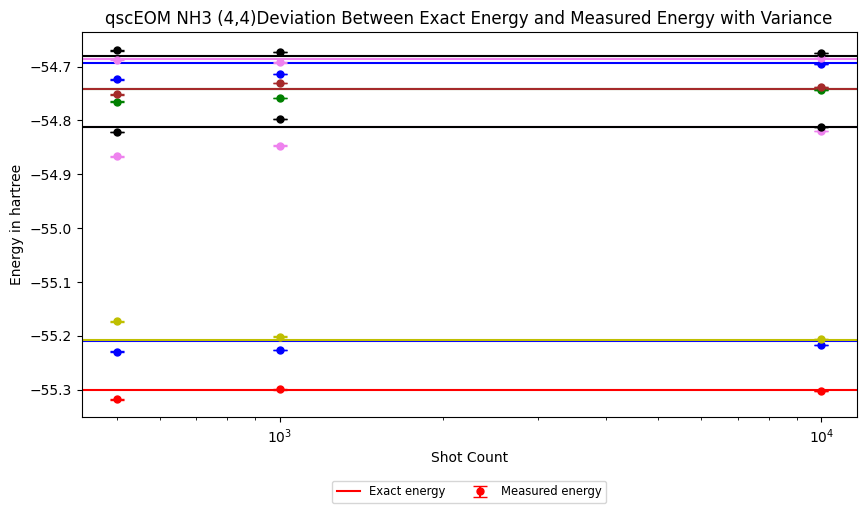

In [ ]:
# Scale factor for error bars 
scale_factor = 3
# Create a figure
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot exact values as horizontal lines
ax1.axhline(y=exact_1_ex, color='r', linestyle='-', label='Exact energy')
ax1.axhline(y=exact_2_ex, color='b', linestyle='-')
ax1.axhline(y=exact_3_ex, color='y', linestyle='-')
ax1.axhline(y=exact_4_ex, color='#EE82EE', linestyle='-')
ax1.axhline(y=exact_5_ex, color='black', linestyle='-')
ax1.axhline(y=exact_6_ex, color='g', linestyle='-')
ax1.axhline(y=exact_7_ex, color='brown', linestyle='-')
ax1.axhline(y=exact_8_ex, color='b', linestyle='-')
ax1.axhline(y=exact_9_ex, color='violet', linestyle='-')
ax1.axhline(y=exact_10_ex, color='black', linestyle='-')



# Plot predicted values as dots with scaled RMSD as error bars
ax1.errorbar(shots, ex1, yerr=var_ex1, fmt='o', color='r', label='Measured energy', capsize=5, markersize=5)
ax1.errorbar(shots, ex2, yerr=var_ex2, fmt='o', color='b', capsize=5, markersize=5)
ax1.errorbar(shots, ex3, yerr=var_ex3, fmt='o', color='y', capsize=5, markersize=5)
ax1.errorbar(shots, ex4, yerr=var_ex4, fmt='o', color='violet', capsize=5, markersize=5)
ax1.errorbar(shots, ex5, yerr=var_ex5, fmt='o', color='black', capsize=5, markersize=5)
ax1.errorbar(shots, ex6, yerr=var_ex6, fmt='o', color='g', capsize=5, markersize=5)
ax1.errorbar(shots, ex7, yerr=var_ex7, fmt='o', color='brown', capsize=5, markersize=5)
ax1.errorbar(shots, ex8, yerr=var_ex8, fmt='o', color='b', capsize=5, markersize=5)
ax1.errorbar(shots, ex9, yerr=var_ex9, fmt='o', color='violet', capsize=5, markersize=5)
ax1.errorbar(shots, ex10, yerr=var_ex10, fmt='o', color='black', capsize=5, markersize=5)



# Set y-axis limit
#ax1.set_ylim(-2.5, -1.1)
plt.xlabel('Shot Count')
ax1.set_ylabel('Energy in hartree')
ax1.set_title('qscEOM NH3 (4,4)Deviation Between Exact Energy and Measured Energy with Variance')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize='small', ncol=4)
#plt.grid(True)
plt.xscale('log')  
plt.show()

